In [1]:
project_id = 'analytics-ahs-owned-thd'
PR='PR'
query_name_list=['falloff_comments']

In [2]:
import logging
import os
os.environ['PROJECT_ID'] = project_id

import time, math, types
from datetime import date, datetime
from google.cloud import bigquery
import pandas as pd
import numpy as np
from preprocess_pipeline_review import *
import nltk
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from google.auth import compute_engine
# import fastcluster
import tensorflow as tf
import tensorflow_hub as hub

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn import metrics
import pickle
from scipy.spatial.distance import cdist


logger = logging.getLogger('hde_falloff_reason')

#print('Packages Loaded')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jlm3455\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
NLP = spacy.load('en_core_web_sm', disable=['ner','textcat'])

Lmtzr = WordNetLemmatizer()

In [4]:
GOOG_USE_PATH = 'https://tfhub.dev/google/universal-sentence-encoder/4'
USE_embed = hub.load(GOOG_USE_PATH)
# MAX_ASPECTS = 20  # maximum number of aspects per OMSID
USE_SIM_THRESH = 0.45 ## threshold for similarity, cosin similarity, google universal sent embed.

In [5]:
# !python -m pip freeze

In [6]:
def get_queries(query_name_list = ['falloff_comments'],PR='PR'):
    if PR=='PR':
        query_directory = os.path.abspath(os.path.join(os.getcwd(), '..','sql'))
    elif PR=='DEV':
        query_directory = os.path.abspath(os.path.join(os.getcwd(), '..','sql_dev'))
    query_list = []
    
        
    for name in query_name_list:
        fd = open(os.path.join(query_directory, name.lower()+".sql"), 'r')
        sqlFile = fd.read()
        fd.close()
        query_list.append(sqlFile)                         
#         query_list.append(sqlFile.format(date.today().strftime("%Y%m%d")))                         
    
    logger.info('Queries Loaded')
    return dict(zip(query_name_list,query_list))
    

In [7]:
def nlp_clean_pipe(text): ## general cleaning pipeline
    ## maybe add spelling correction

    text = formalize_str(text)
    text = replace_URL(text)
    text = filter_stop_sentences(text)
    text = text.replace('set up','setup') # should be handled in a dict like contractions
    text = text.replace('put together','assemble') # should be handled in a dict like contractions
#     text = correct_spelling(text)

    return( text)

In [8]:
def run(query_name_list): #query_name_list,PR,
    pass

query_name_list = [name.lower() for name in query_name_list]
    
bq = bigquery.Client(project=project_id)

queries = get_queries(query_name_list,PR)
bq_data = {}

for name in query_name_list:        
        bq_job = bq.query(queries[name])
        bq_data[name] = bq_job.result().to_dataframe()

C:\Users\jlm3455\OneDrive - The Home Depot\Documents\GIT\hde-falloff-reason\venv\lib\site-packages\google\auth\_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [9]:
# for query in query_name_list:
query = query_name_list[0]

In [10]:
bq_data[query].head()

,ord,rev_ord,liAuditDateTime,liLead,liDate2,LDFUPDATE,TYPE,FALLOFF_FLAG,SELECTED_REASON,WEATHER_FLAG,COMMENTS
0,2,4,2019-07-15 15:25:33,10905366,None,2019-07-19 00:00:00,Unscheduled,True,Unschedule Reason code - Customer Requested,False,' Job in Progress Call' task completed|Comment...
1,3,3,2019-07-18 16:00:51,10905366,2019-07-18 00:00:00,2019-07-19 00:00:00,Rescheduled,False,Unschedule Reason code - Customer Requested,False,Reached Out To Installer Kevin Goodale For An ...
2,4,2,2019-07-18 16:07:51,10905366,None,2019-07-19 00:00:00,Unscheduled,True,Unschedule Reason code - Customer Requested,False,|||coc and voc mentioned.|Comments from HDEWor...
3,5,1,2019-07-18 16:09:21,10905366,2019-07-19 00:00:00,2019-07-19 00:00:00,Rescheduled,False,No reason found,False,coc and voc mentioned.|Comments from HDEWorkfl...
4,2,1,2019-07-29 10:35:21,10905367,2019-08-19 00:00:00,2019-08-19 00:00:00,Rescheduled,False,Reschedule Reason code - Customer Conflict / ...,False,Installation RE-scheduled for 8/12 . Installe...


In [11]:
bq_data[query]['CLEANED_COMMENTS'] = bq_data[query]['COMMENTS'].apply(nlp_clean_pipe)

In [12]:
bq_data[query]['LEMMATIZED_COMMENTS'] = bq_data[query]['CLEANED_COMMENTS'].apply(lambda words:' '.join([Lmtzr.lemmatize(word) for word in words.split()]))

In [13]:
# print(bq_data[query]['CLEANED_COMMENTS'][0])
# print(bq_data[query]['LEMMATIZED_COMMENTS'][0])

In [14]:
bq_data[query]['EMBEDED_COMMENTS'] = bq_data[query]['LEMMATIZED_COMMENTS'].apply(lambda x:list(USE_embed([x])[0].numpy()))

In [15]:
# bq_data[query]['EMBEDED_COMMENTS'].head(1)

In [16]:
kmeans_kwargs = {
     "init": "random",
     "n_init": 10,
     "max_iter": 300,
     "random_state": 42,
 }

min_k = 10
max_k = 20

 # A list holds the SSE values for each k
sse = []
silhouette_coefficients = []
ch_scores = []
models = []
for k in range(min_k, max_k):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(list(bq_data[query]['EMBEDED_COMMENTS']))
    sse.append(kmeans.inertia_)
    score = metrics.silhouette_score(list(bq_data[query]['EMBEDED_COMMENTS']), kmeans.labels_)
    silhouette_coefficients.append(score)
    ch_score = metrics.calinski_harabaz_score(list(bq_data[query]['EMBEDED_COMMENTS']), kmeans.labels_)
    ch_scores.append(ch_score)
    models.append(kmeans)

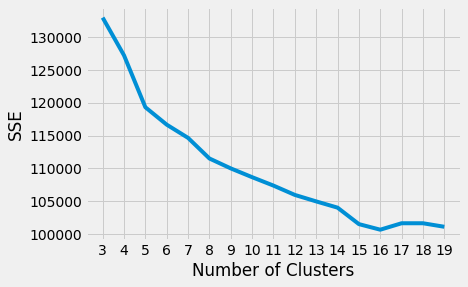

In [17]:
plt.style.use("fivethirtyeight")
plt.plot(range(min_k, max_k), sse)
plt.xticks(range(min_k, max_k))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [18]:
kl = KneeLocator(
        range(min_k, max_k), sse, curve="convex", direction="decreasing"
)
kl.elbow

8

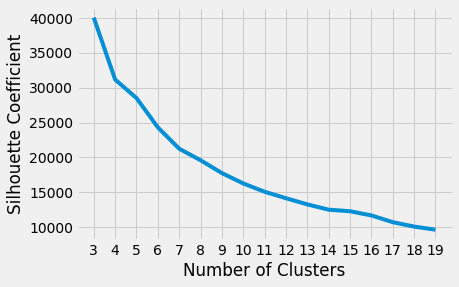

In [19]:
plt.style.use("fivethirtyeight")
plt.plot(range(min_k, max_k), ch_scores)
plt.xticks(range(min_k, max_k))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [20]:
kls = KneeLocator(
        range(min_k, max_k), ch_scores, curve="convex", direction="decreasing"
)
kls.elbow

7

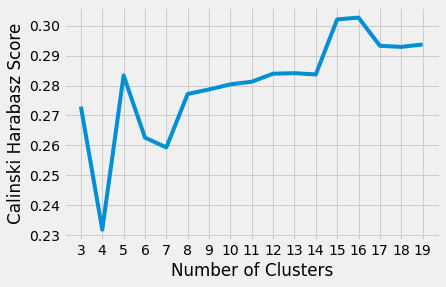

In [21]:
plt.style.use("fivethirtyeight")
plt.plot(range(min_k, max_k), silhouette_coefficients)
plt.xticks(range(min_k, max_k))
plt.xlabel("Number of Clusters")
plt.ylabel("Calinski Harabasz Score")
plt.show()

In [39]:
kmeans_final = models[12]
kmeans_final

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300,
    n_clusters=15, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [40]:
X = list(bq_data[query]['EMBEDED_COMMENTS'])
min_dist = np.min(cdist(X, kmeans_final.cluster_centers_, 'euclidean'), axis=1)

In [41]:
Y = pd.DataFrame(min_dist, columns=['Center_euclidean_dist'])
Z = pd.DataFrame(kmeans_final.labels_.tolist(), columns=['cluster_ID'])
PAP = pd.concat([Y,Z], axis=1)
grouped = PAP.groupby(['cluster_ID'])

In [42]:
grouped.count()

,Center_euclidean_dist
cluster_ID,
0,16338
1,34963
2,28737
3,3524
4,8119
5,11110
6,8225
7,9180
8,19447


In [46]:
PAP2 = PAP
com_ct = 10
com_idxs = {}
for i in range(len(grouped)):
    com_idxs[i] = []
    for j in range(com_ct):
        idx = PAP2.groupby(['cluster_ID']).idxmin().iloc[i,0]
        com_idxs[i].append(idx)
        PAP2.at[idx,'Center_euclidean_dist'] = 100

In [47]:
com_idxs

{0: [8287, 216279, 100954, 100955, 51548, 51549, 91045, 91046, 104337, 104338],
 1: [128, 129, 143, 156, 157, 167, 176, 295, 296, 300],
 2: [47275, 99307, 16197, 15655, 6141, 16375, 46387, 25521, 78641, 118329],
 3: [63755,
  63756,
  152646,
  168173,
  150235,
  174709,
  129629,
  129630,
  205706,
  155472],
 4: [125, 147, 161, 173, 177, 288, 318, 330, 517, 534],
 5: [20175, 51228, 123455, 123456, 74801, 74802, 16455, 172574, 65314, 65315],
 6: [18099, 116104, 83408, 86074, 203556, 184573, 53537, 45315, 73155, 79393],
 7: [866, 867, 979, 1261, 1510, 1511, 1520, 1594, 1598, 1669],
 8: [213335,
  56779,
  47655,
  211373,
  211374,
  188420,
  56780,
  214734,
  37562,
  87502],
 9: [88, 98, 100, 112, 122, 139, 141, 145, 184, 200],
 10: [161410, 186655, 9249, 161409, 18193, 5049, 32656, 175399, 174843, 60892],
 11: [3420, 167583, 99937, 46127, 69852, 6950, 67320, 151573, 47487, 147778],
 12: [94950,
  194363,
  129350,
  167188,
  204916,
  164612,
  210113,
  210114,
  210115,
  210

In [48]:
for cluster in com_idxs:
    print('Cluster',cluster,'(',grouped.count().iloc[cluster,0], 'records) :')
    for idx in com_idxs[cluster]:
        print(bq_data[query].loc[idx,'COMMENTS'])
        print('')
    print('------------------------')

Cluster 0 ( 16338 records) :
|||Customer Called To Reschedule For Tues 8/20 Arriving 8a-10a.

|LVM To Reschedule With Crew 68|Customer Called To Reschedule Install. Message ISC Via Teams||Spoke With Mr. To Reschedule With Correct SP For 7/10 8-10 Arrival|

|Spoke To Ms Day  Confirm Reschedule For 7/30 Arrival 8-10am||||

|Spoke To Ms Day  Confirm Reschedule For 7/30 Arrival 8-10am||||

|||Cust Called Back To RESCHEDULE Install Date|***JOB Is Set For: 	     3/3/2020     8-10  AM--------spoke To Mrs--------ATLAS EXTERIORS***  [[Mrs Called To RE-SCHEDULE]]

|||Cust Called Back To RESCHEDULE Install Date|***JOB Is Set For: 	     3/3/2020     8-10  AM--------spoke To Mrs--------ATLAS EXTERIORS***  [[Mrs Called To RE-SCHEDULE]]

|||LVM FOR BD TO RESCHEDULE RI|****RI RESCHEDULED FOR 06/30 AT 1PM***

|||LVM FOR BD TO RESCHEDULE RI|****RI RESCHEDULED FOR 06/30 AT 1PM***

||||Called Csm To Reschedule Due To Weather Tomorrow. Scheduled For 8/19 12-1pm Arrival.|

||||Called Csm To Reschedule Due T

In [29]:
# models[7]

In [30]:
# with open('kmeans_models', 'wb') as f:
#         pickle.dump(models, f)

In [31]:
# bq_data[query]['LABEL'] = kmeans_final.labels_
# bq_data[query].head()

In [32]:
# bq_data[query].to_csv('data.csv')

In [33]:
# docs = NLP.pipe(bq_data[query]['CLEANED_COMMENTS'], batch_size = 100)

# for doc in docs[0:5]:
#     print([ent for ent in doc.ents])

In [34]:
if __name__ == "__main__":
    run(query_name_list)